<a href="https://colab.research.google.com/github/PebbleBuilds/acc-class/blob/crnn/CRNN_Acc_Class_Rocco_5s_Experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Version History

- Dec 1 - Created.
- Dec 2
    - Added folder concat
    - Added model checkpoint saving
    - Added raw train tester
    - Tested on augmented data

## Config

In [9]:
train_dataset_path = "/content/drive/My Drive/APS360 Group Project/data_testing/roccos-fun-folder/augmented/"
classes = ["english","mandarin","india"]

raw_dataset_path = "/content/drive/My Drive/APS360 Group Project/data_testing/EMI/"

aug = False

if aug:
    train_set_folders = ["EMI_ps2_5s_melspec_numpy", 
    ]

else:
    train_set_folders = []

model_checkpoints_abs_path = "/content/drive/My Drive/APS360 Group Project/model_checkpoints"

## Imports and Colab Mount

In [2]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import ConcatDataset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import librosa
import librosa.display
import os

In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Utility Function Definitions

train_data_components = []
  for folder in train_set_folders:
    folder_path = os.path.join(train_dataset_path, folder, 'train')
    train_data_components.append(torchvision.datasets.ImageFolder(root=os.path.join(folder_path), transform=data_transform))
  train_data = ConcatDataset(train_data_components)

In [6]:
# can also load in data as numpy arrays directly 
def numpy_loader(input):
    item = np.load(input)
    return item

def generate_data_numpy():
  data_transform = transforms.Compose([transforms.ToTensor()])
  raw_train_data = torchvision.datasets.DatasetFolder(root=os.path.join(raw_dataset_path, "train"), loader=numpy_loader,extensions='.npy',transform=data_transform)
  val_data = torchvision.datasets.DatasetFolder(root=os.path.join(raw_dataset_path, "validation"), loader=numpy_loader,extensions='.npy',transform=data_transform)

  train_data_components = [raw_train_data]
  for folder in train_set_folders:
    folder_path = os.path.join(train_dataset_path, folder, 'train')
    train_data_components.append(torchvision.datasets.DatasetFolder(root=folder_path, loader=numpy_loader,extensions='.npy',transform=data_transform))
  train_data = ConcatDataset(train_data_components)
  return train_data, val_data, []

def visualize_numpy_data(dataset):
    batch = 27
    num_workers = 1

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

    # Visualize some sample data
    classes = ['english', 'mandarin', 'india']

    # obtain one batch of training images
    dataiter = iter(data_loader)
    array, labels = dataiter.next()
    array = array.numpy() # convert images to numpy for display
    plt.figure()
    librosa.display.specshow(array[0][0])
    plt.colorbar()

    print("Array shape is", array.shape)
    return array.shape
    
# train utils 

def get_accuracy_rnn(model, data_loader):
    correct = 0
    total = 0
    for array, labels in data_loader:
        if torch.cuda.is_available():
          array = array.cuda()
          labels = labels.cuda()
        input_array = array.float().cuda().transpose(1,2)
        out = model(input_array) 
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += input_array.shape[0]
    return correct / total

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def plot_graphs(iters, train_loss, val_loss, train_acc, val_acc):
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    #plt.plot (iters, val_loss, label = "Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

def get_accuracy_cnn(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        if torch.cuda.is_available():
          imgs = imgs.cuda().float()
          labels = labels.cuda()
        out = model(imgs.float()) 
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total
  
def generate_data_image():
  data_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(224)])
  train_data = torchvision.datasets.ImageFolder(root=os.path.join(raw_dataset_path, "train"), transform=data_transform)
  val_data = torchvision.datasets.ImageFolder(root=os.path.join(raw_dataset_path, "validation"), transform=data_transform)
  #val_data = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/APS360 Group Project/data_testing/pure_augmentation/raw_3classes_13bands_10s_npy/validation', transform=data_transform)
  print(len(train_data))
  print(len(val_data))
  return train_data, val_data, []

def visualize_image_data(dataset):
  batch = 27
  num_workers = 1

  data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

  # Visualize some sample data
  classes = ['english', 'india']

  # obtain one batch of training images
  dataiter = iter(data_loader)
  images, labels = dataiter.next()
  images = images.numpy() # convert images to numpy for display
  # plot the images in the batch, along with the corresponding labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(15):
      ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
      plt.imshow(np.transpose(images[idx], (1, 2, 0)))
      ax.set_title(classes[labels[idx]])
  return images.shape

## Base Arch

In [7]:
class CRNN(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = config.get("num_classes", 3)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(1, 5, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(5, 10, 3) #in_channels, out_chanels, kernel_size

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.RNN(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, nonlinearity=self.nonlinearity, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 10),
                            nn.Linear(10, 8),
                            nn.Linear(8, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()
        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output

    

## Data Gen

Array shape is (27, 1, 128, 216)
128


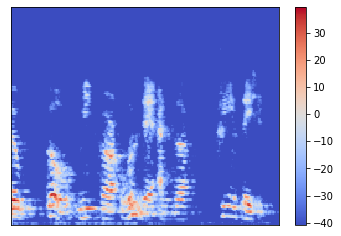

In [10]:
train_data, val_data, []= generate_data_numpy()
(batch_size, dummy, mfcc_bands, length) = visualize_numpy_data(train_data)
#(batch_size, dummy, mfcc_bands, length) = visualize_image_data(train_data)
print(mfcc_bands)

## Train Func

In [16]:
def train_net(net, batch_size=8, num_workers = 1, learning_rate=0.005, num_epochs=30):
    torch.manual_seed(5)
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)

    # The loss function will be Cross Entropy and Optimizer will be Adam.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        mini_batch_total = 0
        epoch_correct = 0
        epoch_total = 0
        for imgs, labels in train_loader:
            # Get the inputs
            if torch.cuda.is_available():
              array = imgs.cuda()
              labels = labels.cuda()
              net = net.cuda()

            # Forward pass, backward pass, and optimize
            input_array = array.squeeze().float().cuda().transpose(1,2)
            # print(input_array.shape)
            out = net(input_array)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Mini_batch Accuracy
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            mini_batch_total = input_array.shape[0]
            mini_batch_acc = mini_batch_correct / mini_batch_total
            train_acc.append(mini_batch_acc)

            # Saving epoch accuracy
            epoch_correct += mini_batch_correct 
            epoch_total += mini_batch_total 

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy_rnn(net, val_loader))  # compute validation accuracy
            n += 1
            mini_b += 1

        print("Epoch: ",epoch,"Train Accuracy: ",epoch_correct/epoch_total,'Val Accuracy: ', val_acc[-1],'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))

        model_name = get_model_name(net.name, batch_size, learning_rate, epoch + 1)
        checkpoint_subdir_path = get_model_name(net.name, batch_size, learning_rate, "_checkpoint_subdir")
        full_checkpoint_path = os.path.join(model_checkpoints_abs_path, checkpoint_subdir_path)
        try:
            torch.save(net.state_dict(), os.path.join(full_checkpoint_path,model_name))
        except FileNotFoundError:
            os.makedirs(full_checkpoint_path)
            torch.save(net.state_dict(), os.path.join(full_checkpoint_path,model_name))
    
        if n % 10 == 0:
            plot_graphs(iters, losses, [], train_acc, val_acc)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( elapsed_time, (elapsed_time / num_epochs) ))

In [17]:
def train_crnn_net(net, batch_size=8, num_workers = 1, learning_rate=0.005, num_epochs=30):
    torch.manual_seed(5)
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)

    # The loss function will be Cross Entropy and Optimizer will be Adam.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    best_val_acc = 0
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        mini_batch_total = 0
        epoch_correct = 0
        epoch_total = 0
        for imgs, labels in train_loader:
            # Get the inputs
            if torch.cuda.is_available():
              array = imgs.cuda()
              labels = labels.cuda()
              net = net.cuda()

            # Forward pass, backward pass, and optimize
            if torch.cuda.is_available():
              input_array = array.float().cuda()
            else:
              input_array = imgs.float()
            out = net(input_array)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Mini_batch Accuracy
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            mini_batch_total = input_array.shape[0]
            mini_batch_acc = mini_batch_correct / mini_batch_total
            train_acc.append(mini_batch_acc)

            # Saving epoch accuracy
            epoch_correct += mini_batch_correct 
            epoch_total += mini_batch_total 

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy_cnn(net, val_loader))  # compute validation accuracy
            n += 1
            mini_b += 1

        print("Epoch: ",epoch,"Train Accuracy: ",epoch_correct/epoch_total,'Val Accuracy: ', val_acc[-1],'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))

        if val_acc[-1]>best_val_acc and val_acc[-1]>0.7:
            print("SAVED MODEL")
            model_name = get_model_name(net.name, batch_size, learning_rate, epoch + 1) + "_valacc_" + str(val_acc[-1])
            checkpoint_subdir_path = get_model_name(net.name, batch_size, learning_rate, str(epoch+1))
            full_checkpoint_path = os.path.join(model_checkpoints_abs_path, checkpoint_subdir_path)
            try:
                torch.save(net.state_dict(), os.path.join(full_checkpoint_path,model_name))
            except FileNotFoundError:
                os.makedirs(full_checkpoint_path)
                torch.save(net.state_dict(), os.path.join(full_checkpoint_path,model_name))
        if val_acc[-1]>best_val_acc:
            best_val_acc = val_acc[-1]
    
        if n % 10 == 0:
            plot_graphs(iters, losses, [], train_acc, val_acc)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( elapsed_time, (elapsed_time / num_epochs) ))

# Dec 6 Experiments

## Exp 1 - GRU, melspec log image

In [12]:
class CRNN(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = 3
        #config.get("num_classes", 2)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(1, 48, 3) #in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(48, 13, 3) #in_channels, out_channels, kernel_size
        self.conv3 = nn.Conv2d(13, 10, 3) #in_channels, out_channels, kernel_size 
        self.batchnorm = nn.BatchNorm2d(48)

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.GRU(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 30),
                                nn.Linear(30,15),
                            nn.Linear(15, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = F.relu(self.conv2(self.batchnorm(x)))
        x = F.relu(self.conv3(x))
        x = torch.reshape(x,(self.batch_size, 1, x.shape[1]*x.shape[2], x.shape[3]))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        if torch.cuda.is_available():
          h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()
        else:
          h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size)

        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output

In [14]:
count = 0

Using CUDA
Epoch:  0 Train Accuracy:  0.3977455716586151 Val Accuracy:  0.4444444444444444 Progress:   2.50  % Time Elapsed:   7.82 s 
Epoch 0 Finished.  Time per Epoch:   7.82 s 
Epoch:  1 Train Accuracy:  0.4074074074074074 Val Accuracy:  0.38271604938271603 Progress:   5.00  % Time Elapsed:  15.79 s 
Epoch 1 Finished.  Time per Epoch:   7.90 s 
Epoch:  2 Train Accuracy:  0.46215780998389694 Val Accuracy:  0.41975308641975306 Progress:   7.50  % Time Elapsed:  23.56 s 
Epoch 2 Finished.  Time per Epoch:   7.85 s 
Epoch:  3 Train Accuracy:  0.4331723027375201 Val Accuracy:  0.2839506172839506 Progress:  10.00  % Time Elapsed:  31.38 s 
Epoch 3 Finished.  Time per Epoch:   7.85 s 
Epoch:  4 Train Accuracy:  0.4605475040257649 Val Accuracy:  0.2962962962962963 Progress:  12.50  % Time Elapsed:  39.13 s 
Epoch 4 Finished.  Time per Epoch:   7.83 s 
Epoch:  5 Train Accuracy:  0.48148148148148145 Val Accuracy:  0.4567901234567901 Progress:  15.00  % Time Elapsed:  47.01 s 
Epoch 5 Finished

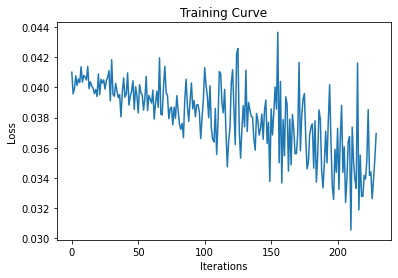

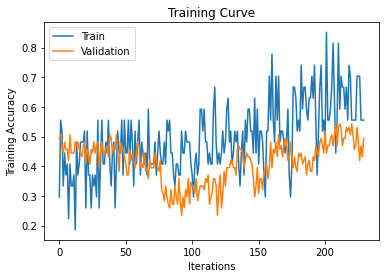

Epoch:  10 Train Accuracy:  0.607085346215781 Val Accuracy:  0.4691358024691358 Progress:  27.50  % Time Elapsed:  86.67 s 
Epoch 10 Finished.  Time per Epoch:   7.88 s 
Epoch:  11 Train Accuracy:  0.6280193236714976 Val Accuracy:  0.5061728395061729 Progress:  30.00  % Time Elapsed:  94.47 s 
Epoch 11 Finished.  Time per Epoch:   7.87 s 
SAVED MODEL
Epoch:  12 Train Accuracy:  0.6392914653784219 Val Accuracy:  0.4074074074074074 Progress:  32.50  % Time Elapsed:  102.40 s 
Epoch 12 Finished.  Time per Epoch:   7.88 s 
Epoch:  13 Train Accuracy:  0.6489533011272142 Val Accuracy:  0.5308641975308642 Progress:  35.00  % Time Elapsed:  110.19 s 
Epoch 13 Finished.  Time per Epoch:   7.87 s 
SAVED MODEL
Epoch:  14 Train Accuracy:  0.6859903381642513 Val Accuracy:  0.5061728395061729 Progress:  37.50  % Time Elapsed:  117.97 s 
Epoch 14 Finished.  Time per Epoch:   7.86 s 
Epoch:  15 Train Accuracy:  0.6924315619967794 Val Accuracy:  0.49382716049382713 Progress:  40.00  % Time Elapsed:  12

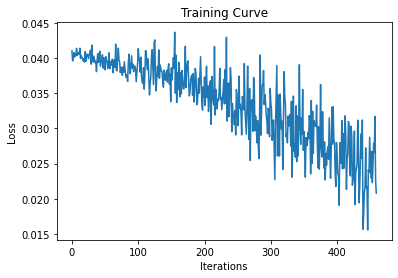

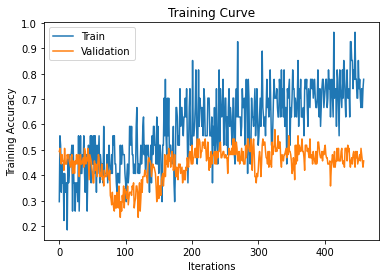

Epoch:  20 Train Accuracy:  0.7922705314009661 Val Accuracy:  0.4691358024691358 Progress:  52.50  % Time Elapsed:  165.05 s 
Epoch 20 Finished.  Time per Epoch:   7.86 s 
Epoch:  21 Train Accuracy:  0.8132045088566827 Val Accuracy:  0.4691358024691358 Progress:  55.00  % Time Elapsed:  172.77 s 
Epoch 21 Finished.  Time per Epoch:   7.85 s 
Epoch:  22 Train Accuracy:  0.7906602254428341 Val Accuracy:  0.49382716049382713 Progress:  57.50  % Time Elapsed:  180.65 s 
Epoch 22 Finished.  Time per Epoch:   7.85 s 
Epoch:  23 Train Accuracy:  0.8180354267310789 Val Accuracy:  0.5185185185185185 Progress:  60.00  % Time Elapsed:  188.51 s 
Epoch 23 Finished.  Time per Epoch:   7.85 s 
Epoch:  24 Train Accuracy:  0.856682769726248 Val Accuracy:  0.5185185185185185 Progress:  62.50  % Time Elapsed:  196.28 s 
Epoch 24 Finished.  Time per Epoch:   7.85 s 
Epoch:  25 Train Accuracy:  0.8389694041867954 Val Accuracy:  0.43209876543209874 Progress:  65.00  % Time Elapsed:  204.06 s 
Epoch 25 Fini

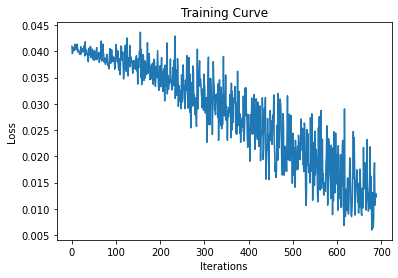

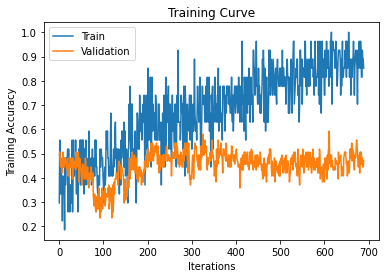

Epoch:  30 Train Accuracy:  0.9178743961352657 Val Accuracy:  0.49382716049382713 Progress:  77.50  % Time Elapsed:  243.07 s 
Epoch 30 Finished.  Time per Epoch:   7.84 s 
Epoch:  31 Train Accuracy:  0.9178743961352657 Val Accuracy:  0.49382716049382713 Progress:  80.00  % Time Elapsed:  250.94 s 
Epoch 31 Finished.  Time per Epoch:   7.84 s 
Epoch:  32 Train Accuracy:  0.9259259259259259 Val Accuracy:  0.49382716049382713 Progress:  82.50  % Time Elapsed:  258.82 s 
Epoch 32 Finished.  Time per Epoch:   7.84 s 
Epoch:  33 Train Accuracy:  0.9436392914653784 Val Accuracy:  0.5679012345679012 Progress:  85.00  % Time Elapsed:  266.57 s 
Epoch 33 Finished.  Time per Epoch:   7.84 s 
SAVED MODEL
Epoch:  34 Train Accuracy:  0.9420289855072463 Val Accuracy:  0.5555555555555556 Progress:  87.50  % Time Elapsed:  274.26 s 
Epoch 34 Finished.  Time per Epoch:   7.84 s 
Epoch:  35 Train Accuracy:  0.9533011272141707 Val Accuracy:  0.5185185185185185 Progress:  90.00  % Time Elapsed:  281.95 s 

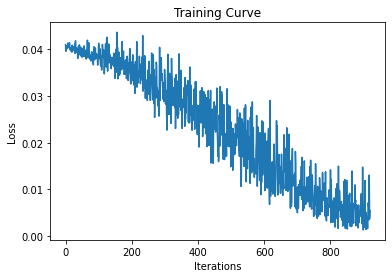

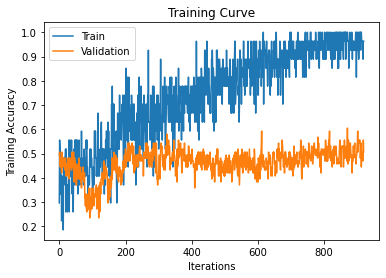

Finished Training
Total time:   313.57 s  Time per Epoch:   7.84 s 


In [26]:
count += 1
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 40
learning_rate = 0.0001
batch_size = 27

config = {
    "name": "GRU_melspec_5s_numpy_exp1_run"+ str(count),
    "num_classes": 3,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 100,
    "nonlinearity": "relu",
    "dropout": 0,
}
acc_net = CRNN(config)
train_crnn_net(acc_net, batch_size = batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

## Exp 2 - Same as above, but with a PS2 folder in there

In [18]:
class CRNN(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = 3
        #config.get("num_classes", 2)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(1, 48, 3) #in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(48, 13, 3) #in_channels, out_channels, kernel_size
        self.conv3 = nn.Conv2d(13, 10, 3) #in_channels, out_channels, kernel_size 
        self.batchnorm = nn.BatchNorm2d(48)

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.GRU(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 30),
                                nn.Linear(30,15),
                            nn.Linear(15, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = F.relu(self.conv2(self.batchnorm(x)))
        x = F.relu(self.conv3(x))
        x = torch.reshape(x,(self.batch_size, 1, x.shape[1]*x.shape[2], x.shape[3]))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        if torch.cuda.is_available():
          h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()
        else:
          h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size)

        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output

In [14]:
count = 0

Using CUDA
Epoch:  0 Train Accuracy:  0.3442879499217527 Val Accuracy:  0.3950617283950617 Progress:   2.50  % Time Elapsed:  267.68 s 
Epoch 0 Finished.  Time per Epoch:  267.68 s 
Epoch:  1 Train Accuracy:  0.45748565466875324 Val Accuracy:  0.37037037037037035 Progress:   5.00  % Time Elapsed:  291.02 s 
Epoch 1 Finished.  Time per Epoch:  145.51 s 
Epoch:  2 Train Accuracy:  0.5357329160146062 Val Accuracy:  0.5185185185185185 Progress:   7.50  % Time Elapsed:  314.37 s 
Epoch 2 Finished.  Time per Epoch:  104.79 s 
Epoch:  3 Train Accuracy:  0.596244131455399 Val Accuracy:  0.4444444444444444 Progress:  10.00  % Time Elapsed:  337.62 s 
Epoch 3 Finished.  Time per Epoch:  84.41 s 
Epoch:  4 Train Accuracy:  0.6171100678142931 Val Accuracy:  0.5555555555555556 Progress:  12.50  % Time Elapsed:  360.93 s 
Epoch 4 Finished.  Time per Epoch:  72.19 s 
Epoch:  5 Train Accuracy:  0.6624934793948879 Val Accuracy:  0.5185185185185185 Progress:  15.00  % Time Elapsed:  384.52 s 
Epoch 5 Fi

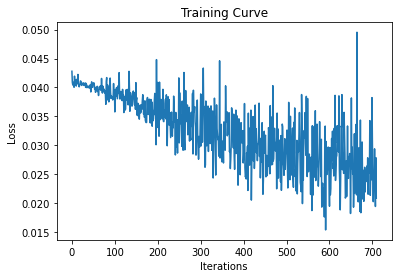

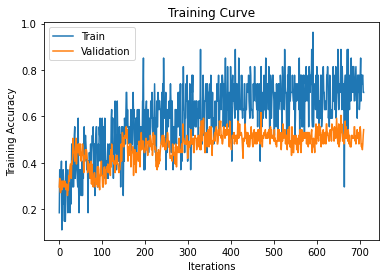

Epoch:  10 Train Accuracy:  0.7454355764214919 Val Accuracy:  0.5432098765432098 Progress:  27.50  % Time Elapsed:  500.91 s 
Epoch 10 Finished.  Time per Epoch:  45.54 s 
Epoch:  11 Train Accuracy:  0.7600417318727178 Val Accuracy:  0.5555555555555556 Progress:  30.00  % Time Elapsed:  523.97 s 
Epoch 11 Finished.  Time per Epoch:  43.66 s 
Epoch:  12 Train Accuracy:  0.784037558685446 Val Accuracy:  0.5432098765432098 Progress:  32.50  % Time Elapsed:  547.20 s 
Epoch 12 Finished.  Time per Epoch:  42.09 s 
Epoch:  13 Train Accuracy:  0.7970787689097548 Val Accuracy:  0.49382716049382713 Progress:  35.00  % Time Elapsed:  570.27 s 
Epoch 13 Finished.  Time per Epoch:  40.73 s 
Epoch:  14 Train Accuracy:  0.8252477829942618 Val Accuracy:  0.5555555555555556 Progress:  37.50  % Time Elapsed:  593.45 s 
Epoch 14 Finished.  Time per Epoch:  39.56 s 
Epoch:  15 Train Accuracy:  0.8440271257172666 Val Accuracy:  0.5432098765432098 Progress:  40.00  % Time Elapsed:  616.60 s 
Epoch 15 Finis

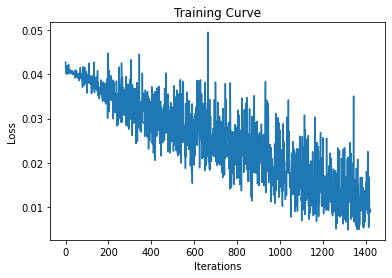

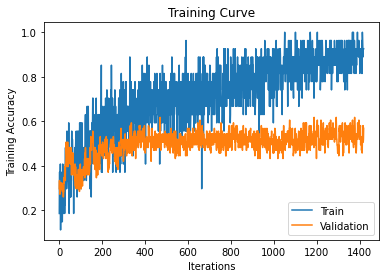

Epoch:  20 Train Accuracy:  0.9128847157016171 Val Accuracy:  0.5185185185185185 Progress:  52.50  % Time Elapsed:  733.31 s 
Epoch 20 Finished.  Time per Epoch:  34.92 s 
Epoch:  21 Train Accuracy:  0.9149713093375065 Val Accuracy:  0.49382716049382713 Progress:  55.00  % Time Elapsed:  756.37 s 
Epoch 21 Finished.  Time per Epoch:  34.38 s 
Epoch:  22 Train Accuracy:  0.9342723004694836 Val Accuracy:  0.5185185185185185 Progress:  57.50  % Time Elapsed:  779.57 s 
Epoch 22 Finished.  Time per Epoch:  33.89 s 
Epoch:  23 Train Accuracy:  0.94679186228482 Val Accuracy:  0.5679012345679012 Progress:  60.00  % Time Elapsed:  802.50 s 
Epoch 23 Finished.  Time per Epoch:  33.44 s 
Epoch:  24 Train Accuracy:  0.9483568075117371 Val Accuracy:  0.5432098765432098 Progress:  62.50  % Time Elapsed:  825.48 s 
Epoch 24 Finished.  Time per Epoch:  33.02 s 
Epoch:  25 Train Accuracy:  0.9619196661450182 Val Accuracy:  0.5555555555555556 Progress:  65.00  % Time Elapsed:  848.63 s 
Epoch 25 Finish

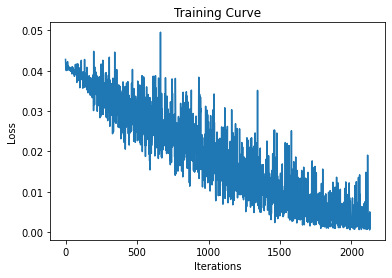

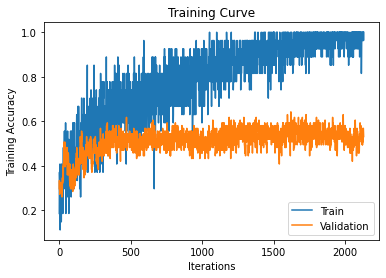

Epoch:  30 Train Accuracy:  0.9796557120500783 Val Accuracy:  0.5061728395061729 Progress:  77.50  % Time Elapsed:  964.47 s 
Epoch 30 Finished.  Time per Epoch:  31.11 s 
Epoch:  31 Train Accuracy:  0.9817423056859677 Val Accuracy:  0.5061728395061729 Progress:  80.00  % Time Elapsed:  988.31 s 
Epoch 31 Finished.  Time per Epoch:  30.88 s 
Epoch:  32 Train Accuracy:  0.9770474700052165 Val Accuracy:  0.5308641975308642 Progress:  82.50  % Time Elapsed:  1011.71 s 
Epoch 32 Finished.  Time per Epoch:  30.66 s 
Epoch:  33 Train Accuracy:  0.9660928534167971 Val Accuracy:  0.5061728395061729 Progress:  85.00  % Time Elapsed:  1035.24 s 
Epoch 33 Finished.  Time per Epoch:  30.45 s 
Epoch:  34 Train Accuracy:  0.9640062597809077 Val Accuracy:  0.4691358024691358 Progress:  87.50  % Time Elapsed:  1058.45 s 
Epoch 34 Finished.  Time per Epoch:  30.24 s 
Epoch:  35 Train Accuracy:  0.9791340636411059 Val Accuracy:  0.5432098765432098 Progress:  90.00  % Time Elapsed:  1081.65 s 
Epoch 35 F

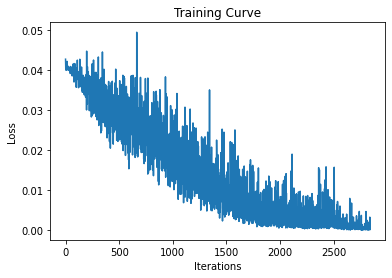

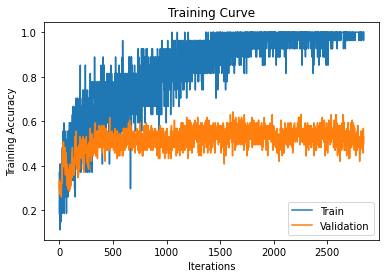

Finished Training
Total time:   1175.03 s  Time per Epoch:  29.38 s 


In [19]:
count += 1
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 40
learning_rate = 0.0001
batch_size = 27

config = {
    "name": "GRU_melspec_5s_numpy_exp2_run"+ str(count),
    "num_classes": 3,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 100,
    "nonlinearity": "relu",
    "dropout": 0,
}
acc_net = CRNN(config)
train_crnn_net(acc_net, batch_size = batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

## Exp 3 - Beeger conv layers GRU, no batch norm

In [28]:
class CRNN(nn.Module):
    def __init__(self, config):
        # input params
        self.name = config.get("name", "CRNN_placeholder")
        self.num_classes = 3
        #config.get("num_classes", 2)
        # for CNN
        self.input_dims = config.get("input_dims", [0])
        # for RNN
        self.hidden_size = config.get("hidden_size", 0)
        self.nonlinearity = config.get("nonlinearity", 'relu')
        self.dropout = config.get("dropout", 0)
        self.batch_size = self.input_dims[0]
        
        super(CRNN, self).__init__()
        # CNN layers
        self.conv1 = nn.Conv2d(1, 25, 3) #in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
        self.conv2 = nn.Conv2d(25, 50, 3) #in_channels, out_channels, kernel_size
        self.conv3 = nn.Conv2d(50, 100, 3) #in_channels, out_channels, kernel_size 
        self.batchnorm = nn.BatchNorm2d(25)

        # CNN output dimension
        self.conv_output_dim = self.dimension_checker()

        # RNN layers
        self.rnn = nn.GRU(input_size=self.conv_output_dim[-1], hidden_size=self.hidden_size, batch_first=True, num_layers=self.num_classes, dropout=self.dropout)

        # Fully connected layers
        self.fc = nn.Sequential(nn.Linear(self.hidden_size, 70),
                                nn.Linear(70,40),
                            nn.Linear(40, self.num_classes),)

    def dimension_checker(self):
        dummy = torch.empty(self.input_dims)
        return(tuple(self.conv_portion(dummy).shape))

    def conv_portion(self, img):
        # print(img.shape)
        x = self.pool(F.relu(self.conv1(img)))
        x = F.relu(self.conv2(self.batchnorm(x)))
        x = F.relu(self.conv3(x))
        x = torch.reshape(x,(self.batch_size, 1, x.shape[1]*x.shape[2], x.shape[3]))
        x = x.squeeze().transpose(1,2)
        return x

    def forward(self, input):
        x = self.conv_portion(input)
        if torch.cuda.is_available():
          h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size).cuda()
        else:
          h0 = torch.zeros(self.num_classes, self.batch_size, self.hidden_size)

        out, _ = self.rnn(x, h0)
        output = self.fc(torch.max(out, dim=1)[0])
        return output

In [23]:
count = 0

Using CUDA
Epoch:  0 Train Accuracy:  0.39697443922796033 Val Accuracy:  0.37037037037037035 Progress:   5.00  % Time Elapsed:  27.87 s 
Epoch 0 Finished.  Time per Epoch:  27.87 s 
Epoch:  1 Train Accuracy:  0.5226917057902973 Val Accuracy:  0.49382716049382713 Progress:  10.00  % Time Elapsed:  55.47 s 
Epoch 1 Finished.  Time per Epoch:  27.74 s 
Epoch:  2 Train Accuracy:  0.6004173187271779 Val Accuracy:  0.5061728395061729 Progress:  15.00  % Time Elapsed:  83.05 s 
Epoch 2 Finished.  Time per Epoch:  27.68 s 
Epoch:  3 Train Accuracy:  0.6609285341679708 Val Accuracy:  0.48148148148148145 Progress:  20.00  % Time Elapsed:  110.31 s 
Epoch 3 Finished.  Time per Epoch:  27.58 s 
Epoch:  4 Train Accuracy:  0.6817944705268649 Val Accuracy:  0.5308641975308642 Progress:  25.00  % Time Elapsed:  137.68 s 
Epoch 4 Finished.  Time per Epoch:  27.54 s 
Epoch:  5 Train Accuracy:  0.7271778821074596 Val Accuracy:  0.49382716049382713 Progress:  30.00  % Time Elapsed:  165.12 s 
Epoch 5 Fini

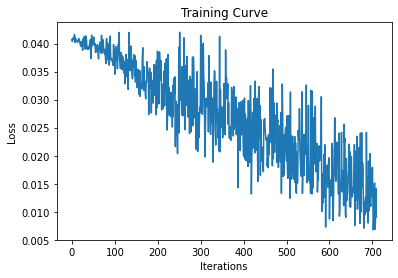

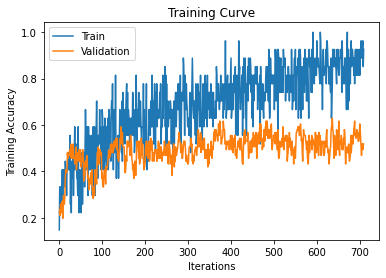

Epoch:  10 Train Accuracy:  0.92018779342723 Val Accuracy:  0.6049382716049383 Progress:  55.00  % Time Elapsed:  302.58 s 
Epoch 10 Finished.  Time per Epoch:  27.51 s 
Epoch:  11 Train Accuracy:  0.917057902973396 Val Accuracy:  0.5802469135802469 Progress:  60.00  % Time Elapsed:  330.07 s 
Epoch 11 Finished.  Time per Epoch:  27.51 s 
Epoch:  12 Train Accuracy:  0.9504434011476265 Val Accuracy:  0.49382716049382713 Progress:  65.00  % Time Elapsed:  357.47 s 
Epoch 12 Finished.  Time per Epoch:  27.50 s 
Epoch:  13 Train Accuracy:  0.9723526343244653 Val Accuracy:  0.49382716049382713 Progress:  70.00  % Time Elapsed:  384.60 s 
Epoch 13 Finished.  Time per Epoch:  27.47 s 
Epoch:  14 Train Accuracy:  0.9869587897756912 Val Accuracy:  0.5679012345679012 Progress:  75.00  % Time Elapsed:  411.66 s 
Epoch 14 Finished.  Time per Epoch:  27.44 s 
Epoch:  15 Train Accuracy:  0.9843505477308294 Val Accuracy:  0.5432098765432098 Progress:  80.00  % Time Elapsed:  438.54 s 
Epoch 15 Finish

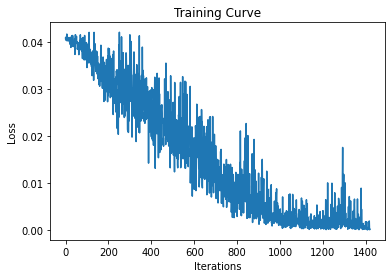

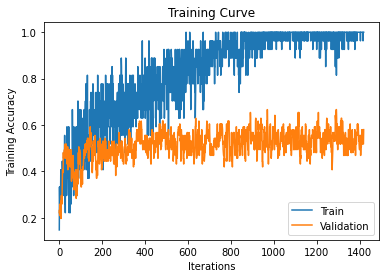

Finished Training
Total time:   545.56 s  Time per Epoch:  27.28 s 


In [29]:
count += 1
if torch.cuda.is_available():
  print("Using CUDA")
num_epochs = 20
learning_rate = 0.0001
batch_size = 27

config = {
    "name": "GRU_melspec_5s_numpy_exp3_run"+ str(count),
    "num_classes": 3,
    "input_dims": (batch_size, dummy, mfcc_bands, length),
    "hidden_size": 100,
    "nonlinearity": "relu",
    "dropout": 0,
}
acc_net = CRNN(config)
train_crnn_net(acc_net, batch_size = batch_size, learning_rate = learning_rate, num_epochs = num_epochs)